In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.rcParams['figure.figsize'] = [10, 10]

def salt(im,percent):
    image = im.copy()
    siz =im.shape[0]*im.shape[1]
    xys = random.sample(range(siz), int(siz*percent))
    coords = [divmod(xy, im.shape[1]) for xy in xys]
    # apply noise to coordinates
    for c in coords:
        image[c]=np.random.randint(2)
    return image,coords

def rvin(im,percent):
    image = im.copy()
    siz =im.shape[0]*im.shape[1]
    xys = random.sample(range(siz), int(siz*percent))
    coords = [divmod(xy, im.shape[1]) for xy in xys]
    # apply noise to coordinates
    for c in coords:
        image[c]=np.random.uniform(0, 1)
    return image,coords

def extract(sa,csalt):
    labels = np.zeros(sa.shape)
    for c in csalt:
        labels[c]=1
    x = []
    y = []
    for i in range(sa.shape[0]):
        for j in range(sa.shape[1]):
            if (i > 0) & (j > 0) & (i < sa.shape[0]-1) & (j < sa.shape[1]-1):
                x.append((sa[i-1][j+1], sa[i][j+1], sa[i+1][j+1], 
                        sa[i-1][j], sa[i][j], sa[i+1][j], 
                        sa[i-1][j-1], sa[i][j-1], sa[i+1][j-1]))
                y.append(labels[i][j])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [2]:
# extract pixel noise labels and features for training from 10 images
xt = []
yt = []
for filename in os.listdir('train/'):
    im = imread('train/'+filename)/255
    percents = [.2,.4,.6]
    for p in percents:
        sa,csalt = salt(im,p)
        rv,crvin = rvin(im,p)
        xsa,ysa = extract(sa, csalt)
        xrv,yrv = extract(rv, crvin)
        xt.extend(xsa)
        xt.extend(xrv)
        yt.extend(ysa)
        yt.extend(yrv)
xt = np.array(xt)
yt = np.array(yt)

In [10]:
len(yt)

15991608

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, Dropout, 
                          MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Define arquitecture
model = Sequential()
model.add(Dense(32, input_dim=9, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam',loss="mse", metrics=["mse"])

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

checkpointer = ModelCheckpoint(filepath="pixel_noise_model.h5",
                               verbose=1, save_best_only=True)

x_train, x_test, y_train, y_test = train_test_split(xt, yt, test_size=0.2,
                                                    random_state=42)

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=3,
          validation_split=0.2,
          #callbacks = [reduce_lr],
          callbacks = [reduce_lr,checkpointer],
          verbose=1)

Epoch 1/3
39980/39980 [==============================] - 58s 1ms/step - loss: 0.1045 - mse: 0.1045 - val_loss: 0.0878 - val_mse: 0.0878 - lr: 0.0010
Epoch 2/3
39980/39980 [==============================] - 51s 1ms/step - loss: 0.0953 - mse: 0.0953 - val_loss: 0.0841 - val_mse: 0.0841 - lr: 9.0000e-04
Epoch 3/3
39980/39980 [==============================] - 51s 1ms/step - loss: 0.0934 - mse: 0.0934 - val_loss: 0.0831 - val_mse: 0.0831 - lr: 8.1000e-04


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("RNN Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [4]:
def decode(score):
    return 1 if score>0.5 else 0

def accuracy(y_true, y_pred):
    if not (len(y_true) == len(y_pred)):
        print('Size of predicted and true labels not equal.')
        return 0.0
    corr = 0
    for i in range(0,len(y_true)):
        corr += 1 if (y_true[i] == y_pred[i]).all() else 0
    return corr/len(y_true)

scores = model.predict(x_test, verbose=1, batch_size=100)
y2 = [decode(score) for score in scores]
calc = accuracy(y_test, y2)
print('Test Accuracy = {}'.format(calc))

31984/31984 [==============================] - 15s 463us/step
Test Accuracy = 0.8891256102418705


In [11]:
def extractFilter(clean,noisy):
    x = []
    y = []
    im = noisy.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if (i > 0) & (j > 0) & (i < im.shape[0]-1) & (j < im.shape[1]-1):
                x.append((im[i-1][j+1], im[i][j+1], im[i+1][j+1], 
                        im[i-1][j], im[i+1][j], 
                        im[i-1][j-1], im[i][j-1], im[i+1][j-1]))
                y.append(clean[i][j])
    x = np.array(x)
    y = np.array(y)
    return x,y

# extract clean pixel from clean image and surrounding noisy pixels
xt = []
yt = []
for filename in os.listdir('train/'):
    imag = imread('train/'+filename)/255
    percents = [.2,.4,.6]
    for p in percents:
        sa,csalt = salt(imag,p)
        rv,crvin = rvin(imag,p)
        xsa,ysa = extractFilter(imag, sa)
        xrv,yrv = extractFilter(imag, rv)
        xt.extend(xsa)
        xt.extend(xrv)
        yt.extend(ysa)
        yt.extend(yrv)
xt = np.array(xt)
yt = np.array(yt)

In [12]:
len(yt)

15991608

In [14]:
xt = np.reshape(xt, (xt.shape[0],8,1))
yt = yt.reshape(-1,1)

In [15]:
from tensorflow.keras.layers import (Dense, Bidirectional, LSTM, Concatenate, 
                                     Dropout, Embedding, GRU, SimpleRNN,
                                     Input, Attention, GlobalMaxPool1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Define arquitecture
model2 = Sequential()
model2.add(SimpleRNN(32,return_sequences=True, activation='relu',input_shape=(8,1)))
model2.add(SimpleRNN(16))
model2.add(Dropout(0.3))
model2.add(Dense(1))

model2.compile(optimizer='adam',loss="mse", metrics=["mse"])

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

checkpointer = ModelCheckpoint(filepath="pixel_rnn_model.h5",
                               verbose=1, save_best_only=True)

x_train, x_test, y_train, y_test = train_test_split(xt, yt, test_size=0.2,
                                                    random_state=42)

history2 = model2.fit(x_train, y_train,
          batch_size=256,
          epochs=11,
          validation_split=0.2,
          #callbacks = [reduce_lr],
          callbacks = [reduce_lr,checkpointer],
          verbose=1)

Epoch 1/3
39980/39980 [==============================] - 130s 3ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0148 - val_mse: 0.0148 - lr: 0.0010
Epoch 2/3
39980/39980 [==============================] - 119s 3ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0136 - val_mse: 0.0136 - lr: 9.0000e-04
Epoch 3/3
39980/39980 [==============================] - 133s 3ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0138 - val_mse: 0.0138 - lr: 8.1000e-04


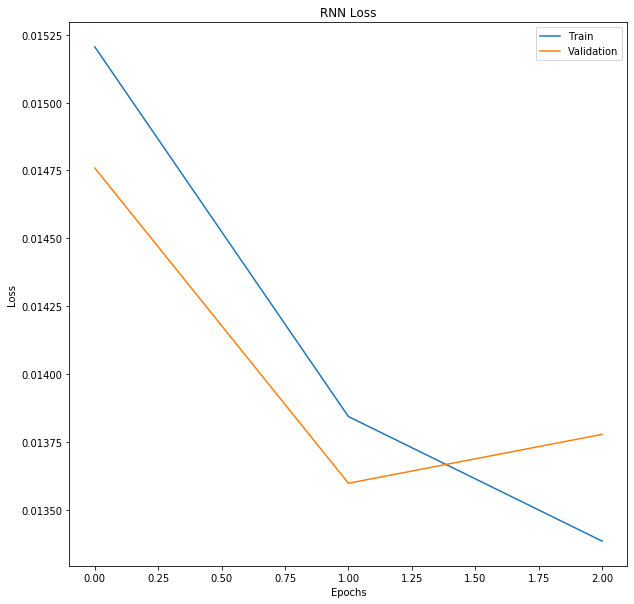

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("RNN Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [34]:
def extractSurrounding(noisy):
    x = []
    im = noisy.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if (i > 0) & (j > 0) & (i < im.shape[0]-1) & (j < im.shape[1]-1):
                x.append((im[i-1][j+1], im[i][j+1], im[i+1][j+1], 
                        im[i-1][j], im[i+1][j], 
                        im[i-1][j-1], im[i][j-1], im[i+1][j-1]))
    x = np.array(x)
    x = np.reshape(x, (x.shape[0],8,1))
    return x

def switchrnn(im,coords,rnnn):
    rnnout = im.copy()
    for c in coords:
        if (c[0] > 0) & (c[1] > 0) & (c[0] < rnnout.shape[0]-1) & (c[1] < rnnout.shape[1]-1):
            rnnout[c] = rnnn[c[0]-1,c[1]-1]
    return rnnout

def getcoords(noisy):
    pass

In [64]:
noises = []
ends = []
psnrs = []

for filename in os.listdir('test/'):
    imag = imread('test/'+filename)/255
    percents = [.2,.4,.6]
    for p in percents:
        #add noise to the image
        sa,csalt = salt(imag,p)
        #create a prediction for all pixels on the image
        surroundFeatures = extractSurrounding(sa)
        predimg = model2.predict(surroundFeatures, verbose=1, batch_size=100)
        predimg = np.reshape(predimg, (imag.shape[0]-2,imag.shape[1]-2))
        #switch only the noisy pixels from the predicted coordinates
        end = switchrnn(sa,csalt,predimg)
        mse = (abs(end*255 - imag*255)).mean(axis=None)
        psnr = 10*np.log10((255*255)/mse)
        ends.append(end)
        psnrs.append(psnr)
        noises.append(sa)

2601/2601 [==============================] - 3s 1ms/step


(-0.5, 511.5, 511.5, -0.5)

<Figure size 1440x792 with 0 Axes>

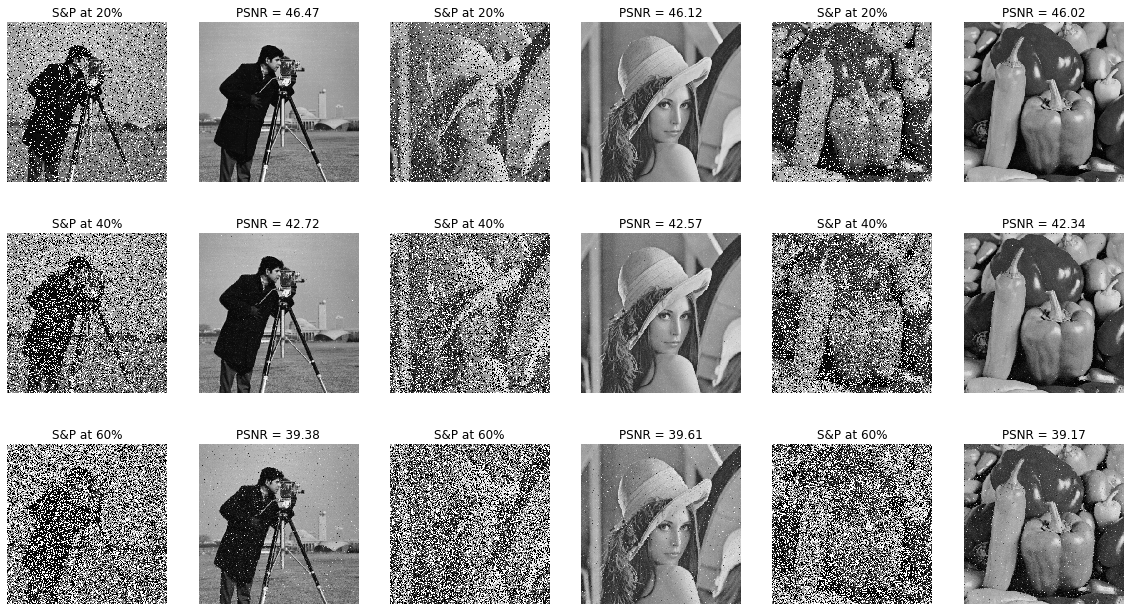

In [65]:
plt.rcParams['figure.figsize'] = [20, 11]
plt.figure()
f, axarr = plt.subplots(3,6) 
axarr[0,0].imshow(noises[0], cmap='gray', vmin=0, vmax=1)
axarr[0,0].set_title("S&P at 20%")
axarr[0,0].axis('off')
axarr[1,0].imshow(noises[1], cmap='gray', vmin=0, vmax=1)
axarr[1,0].set_title("S&P at 40%")
axarr[1,0].axis('off')
axarr[2,0].imshow(noises[2], cmap='gray', vmin=0, vmax=1)
axarr[2,0].set_title("S&P at 60%")
axarr[2,0].axis('off')
axarr[0,1].imshow(ends[0], cmap='gray', vmin=0, vmax=1)
axarr[0,1].set_title("PSNR = {:.02f}".format(psnrs[0]))
axarr[0,1].axis('off')
axarr[1,1].imshow(ends[1], cmap='gray', vmin=0, vmax=1)
axarr[1,1].set_title("PSNR = {:.02f}".format(psnrs[1]))
axarr[1,1].axis('off')
axarr[2,1].imshow(ends[2], cmap='gray', vmin=0, vmax=1)
axarr[2,1].set_title("PSNR = {:.02f}".format(psnrs[2]))
axarr[2,1].axis('off')

axarr[0,2].imshow(noises[3], cmap='gray', vmin=0, vmax=1)
axarr[0,2].set_title("S&P at 20%")
axarr[0,2].axis('off')
axarr[1,2].imshow(noises[4], cmap='gray', vmin=0, vmax=1)
axarr[1,2].set_title("S&P at 40%")
axarr[1,2].axis('off')
axarr[2,2].imshow(noises[5], cmap='gray', vmin=0, vmax=1)
axarr[2,2].set_title("S&P at 60%")
axarr[2,2].axis('off')
axarr[0,3].imshow(ends[3], cmap='gray', vmin=0, vmax=1)
axarr[0,3].set_title("PSNR = {:.02f}".format(psnrs[3]))
axarr[0,3].axis('off')
axarr[1,3].imshow(ends[4], cmap='gray', vmin=0, vmax=1)
axarr[1,3].set_title("PSNR = {:.02f}".format(psnrs[4]))
axarr[1,3].axis('off')
axarr[2,3].imshow(ends[5], cmap='gray', vmin=0, vmax=1)
axarr[2,3].set_title("PSNR = {:.02f}".format(psnrs[5]))
axarr[2,3].axis('off')

axarr[0,4].imshow(noises[6], cmap='gray', vmin=0, vmax=1)
axarr[0,4].set_title("S&P at 20%")
axarr[0,4].axis('off')
axarr[1,4].imshow(noises[7], cmap='gray', vmin=0, vmax=1)
axarr[1,4].set_title("S&P at 40%")
axarr[1,4].axis('off')
axarr[2,4].imshow(noises[8], cmap='gray', vmin=0, vmax=1)
axarr[2,4].set_title("S&P at 60%")
axarr[2,4].axis('off')
axarr[0,5].imshow(ends[6], cmap='gray', vmin=0, vmax=1)
axarr[0,5].set_title("PSNR = {:.02f}".format(psnrs[6]))
axarr[0,5].axis('off')
axarr[1,5].imshow(ends[7], cmap='gray', vmin=0, vmax=1)
axarr[1,5].set_title("PSNR = {:.02f}".format(psnrs[7]))
axarr[1,5].axis('off')
axarr[2,5].imshow(ends[8], cmap='gray', vmin=0, vmax=1)
axarr[2,5].set_title("PSNR = {:.02f}".format(psnrs[8]))
axarr[2,5].axis('off')

In [ ]:
noises = []
ends = []
psnrs = []

for filename in os.listdir('test/'):
    imag = imread('test/'+filename)/255
    percents = [.2,.4,.6]
    for p in percents:
        #add noise to the image
        sa,csalt = rvin(imag,p)
        #create a prediction for all pixels on the image
        surroundFeatures = extractSurrounding(sa)
        predimg = model2.predict(surroundFeatures, verbose=1, batch_size=100)
        predimg = np.reshape(predimg, (imag.shape[0]-2,imag.shape[1]-2))
        #switch only the noisy pixels from the predicted coordinates
        end = switchrnn(sa,csalt,predimg)
        mse = (abs(end*255 - imag*255)).mean(axis=None)
        psnr = 10*np.log10((255*255)/mse)
        ends.append(end)
        psnrs.append(psnr)
        noises.append(sa)


(-0.5, 511.5, 511.5, -0.5)

<Figure size 1440x792 with 0 Axes>

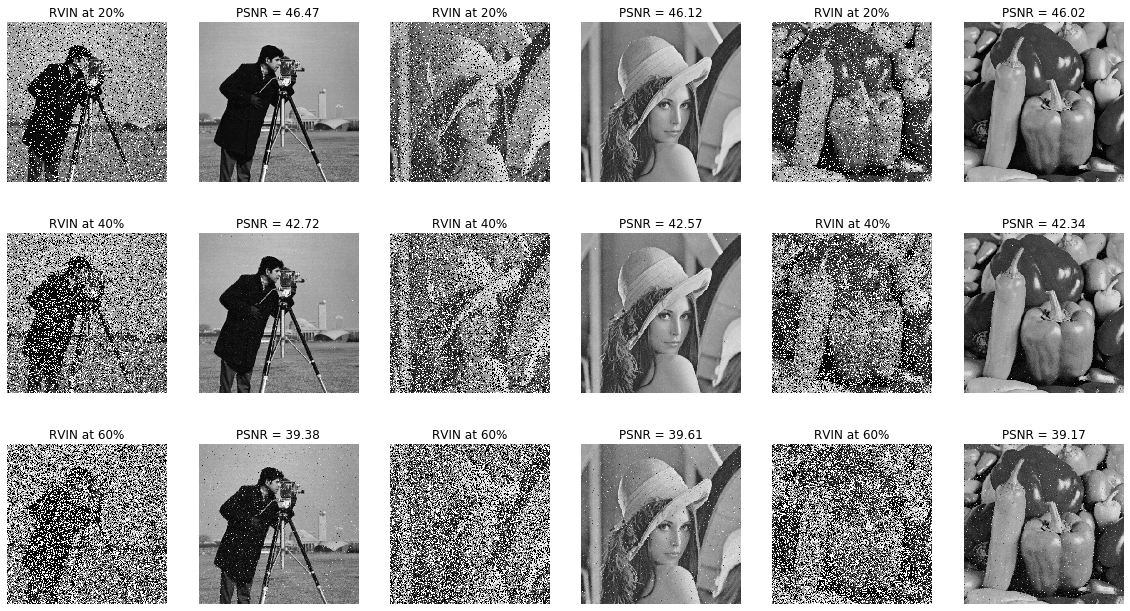

In [66]:
plt.rcParams['figure.figsize'] = [20, 11]
plt.figure()
f, axarr = plt.subplots(3,6) 
axarr[0,0].imshow(noises[0], cmap='gray', vmin=0, vmax=1)
axarr[0,0].set_title("RVIN at 20%")
axarr[0,0].axis('off')
axarr[1,0].imshow(noises[1], cmap='gray', vmin=0, vmax=1)
axarr[1,0].set_title("RVIN at 40%")
axarr[1,0].axis('off')
axarr[2,0].imshow(noises[2], cmap='gray', vmin=0, vmax=1)
axarr[2,0].set_title("RVIN at 60%")
axarr[2,0].axis('off')
axarr[0,1].imshow(ends[0], cmap='gray', vmin=0, vmax=1)
axarr[0,1].set_title("PSNR = {:.02f}".format(psnrs[0]))
axarr[0,1].axis('off')
axarr[1,1].imshow(ends[1], cmap='gray', vmin=0, vmax=1)
axarr[1,1].set_title("PSNR = {:.02f}".format(psnrs[1]))
axarr[1,1].axis('off')
axarr[2,1].imshow(ends[2], cmap='gray', vmin=0, vmax=1)
axarr[2,1].set_title("PSNR = {:.02f}".format(psnrs[2]))
axarr[2,1].axis('off')


axarr[0,2].imshow(noises[3], cmap='gray', vmin=0, vmax=1)
axarr[0,2].set_title("RVIN at 20%")
axarr[0,2].axis('off')
axarr[1,2].imshow(noises[4], cmap='gray', vmin=0, vmax=1)
axarr[1,2].set_title("RVIN at 40%")
axarr[1,2].axis('off')
axarr[2,2].imshow(noises[5], cmap='gray', vmin=0, vmax=1)
axarr[2,2].set_title("RVIN at 60%")
axarr[2,2].axis('off')
axarr[0,3].imshow(ends[3], cmap='gray', vmin=0, vmax=1)
axarr[0,3].set_title("PSNR = {:.02f}".format(psnrs[3]))
axarr[0,3].axis('off')
axarr[1,3].imshow(ends[4], cmap='gray', vmin=0, vmax=1)
axarr[1,3].set_title("PSNR = {:.02f}".format(psnrs[4]))
axarr[1,3].axis('off')
axarr[2,3].imshow(ends[5], cmap='gray', vmin=0, vmax=1)
axarr[2,3].set_title("PSNR = {:.02f}".format(psnrs[5]))
axarr[2,3].axis('off')


axarr[0,4].imshow(noises[6], cmap='gray', vmin=0, vmax=1)
axarr[0,4].set_title("RVIN at 20%")
axarr[0,4].axis('off')
axarr[1,4].imshow(noises[7], cmap='gray', vmin=0, vmax=1)
axarr[1,4].set_title("RVIN at 40%")
axarr[1,4].axis('off')
axarr[2,4].imshow(noises[8], cmap='gray', vmin=0, vmax=1)
axarr[2,4].set_title("RVIN at 60%")
axarr[2,4].axis('off')
axarr[0,5].imshow(ends[6], cmap='gray', vmin=0, vmax=1)
axarr[0,5].set_title("PSNR = {:.02f}".format(psnrs[6]))
axarr[0,5].axis('off')
axarr[1,5].imshow(ends[7], cmap='gray', vmin=0, vmax=1)
axarr[1,5].set_title("PSNR = {:.02f}".format(psnrs[7]))
axarr[1,5].axis('off')
axarr[2,5].imshow(ends[8], cmap='gray', vmin=0, vmax=1)
axarr[2,5].set_title("PSNR = {:.02f}".format(psnrs[8]))
axarr[2,5].axis('off')